In [49]:
%matplotlib inline 
import pickle
import random
import numpy as np
import pylab as pl

laser_position = []
odom_position = []
gazebo_position = []

odom_x = []
odom_y = []
odom_z = []
gazebo_x = []
gazebo_y = []
gazebo_z = []
laser_x = []
laser_y = []
laser_z = []

odom_roll = []
odom_pitch = []
odom_yaw = []
gazebo_roll = []
gazebo_pitch = []
gazebo_yaw = []

odom_velx = []
odom_vely = []
odom_velz = []

fuse_x = []
fuse_y = []
fuse_z = []

vel_x = []
vel_y = []
vel_z = []

vel_acu_x = 0
vel_acu_y = 0
vel_acu_z = 0

distance_x = 0.0
distance_y = 0.0
distance_z = 0.0


fuse_time_x = 0.0
fuse_time_y = 0.0
fuse_time_z = 0.0
fuse_vel_x = 0.0
fuse_vel_y = 0.0
fuse_vel_z = 0.0
fuse_position_x = 0.0
fuse_position_y = 0.0
fuse_position_z = 0.0

#读取预先存好的数据
f=open('./laser.p', 'rb')
while 1:
    try:
        laser_position.append(pickle.load(f))
    except EOFError:
        break
f.close()

f=open('./odom.p', 'rb')
while 1:
    try:
        odom_position.append(pickle.load(f))
    except EOFError:
        break
f.close()

f=open('./gazebo.p', 'rb')
while 1:
    try:
        gazebo_position.append(pickle.load(f))
    except EOFError:
        break
f.close()
#多了一个外框，处理一下
laser_position = laser_position[0]
odom_position = odom_position[0]
gazebo_position = gazebo_position[0]

print (np.shape(laser_position),np.shape(gazebo_position),np.shape(odom_position))

#循环写入原先对应的list，其中每个list的第一个是时间第二个是数据
for i in range(np.shape(laser_position)[0]):
    #print laser_position[i][3]
    if laser_position[i][1] > 30:
        laser_position[i][1] = 0
    if laser_position[i][2] > 30:
        laser_position[i][2] = 0
    if laser_position[i][3] > 30:
        laser_position[i][3] = 0
    laser_x.append([laser_position[i][0], laser_position[i][1]])
    laser_y.append([laser_position[i][0], laser_position[i][2]])
    laser_z.append([laser_position[i][0], laser_position[i][3]])

for i in range(np.shape(gazebo_position)[0]):
    gazebo_x.append([gazebo_position[i][0], gazebo_position[i][1]])
    gazebo_y.append([gazebo_position[i][0], gazebo_position[i][2]])
    gazebo_z.append([gazebo_position[i][0], gazebo_position[i][3]]) 
    gazebo_roll.append([gazebo_position[i][0], gazebo_position[i][4]])
    gazebo_pitch.append([gazebo_position[i][0], gazebo_position[i][5]])
    gazebo_yaw.append([gazebo_position[i][0], gazebo_position[i][6]]) 
    
for i in range(np.shape(odom_position)[0]):
    odom_x.append([odom_position[i][0], odom_position[i][1]])
    odom_y.append([odom_position[i][0], odom_position[i][2]])
    odom_z.append([odom_position[i][0], odom_position[i][3]]) 
    odom_roll.append([odom_position[i][0], odom_position[i][4]])
    odom_pitch.append([odom_position[i][0], odom_position[i][5]])
    odom_yaw.append([odom_position[i][0], odom_position[i][6]]) 
    odom_velx.append([odom_position[i][0], odom_position[i][7]])
    odom_vely.append([odom_position[i][0], odom_position[i][8]])
    odom_velz.append([odom_position[i][0], odom_position[i][9]]) 
    
print '数据读取完成'

((4800, 4), (24000, 7), (24000, 10))
数据读取完成


In [50]:
#积分算位置 sum(deltaT*v)
vel_num = np.shape(odom_velx)[0]
laser_num = np.shape(laser_position)[0]
for i in range(vel_num):
    if i == vel_num-1:
        break
    distance_x = distance_x + (odom_velx[i + 1][0] - odom_velx[i][0]) * odom_velx[i][1]
    vel_x.append([odom_velx[i + 1][0], distance_x]) 
    
    distance_y = distance_y + (odom_vely[i + 1][0] - odom_vely[i][0]) * odom_vely[i][1]
    vel_y.append([odom_vely[i + 1][0], distance_y]) 
    
    distance_z = distance_z + (odom_velz[i + 1][0] - odom_velz[i][0]) * odom_velz[i][1]
    vel_z.append([odom_velz[i + 1][0], distance_z]) 

print '基于加速度的位置计算完成'

基于加速度的位置计算完成


In [51]:
#激光雷达range和IMU速度，数据融合
#用两个变量来卡时间
#保持帧同步，这里舍弃激光雷达第一帧，和在激光雷达第一帧之前的imu帧，用激光雷达前一帧的imu帧来作为激光雷达第一帧的速度。
#然后从激光雷达第一帧开始计算距离。= Plidar+deltaT * V
index = 0
#锁定时间区间
time1 = laser_position[1][0]
time2 = laser_position[2][0]
for i in range(laser_num - 2):
    time1 = laser_position[i + 1][0]
    time2 = laser_position[i + 2][0]

    
    #找出刚好大于time1的时间点，之前的一个就是刚好小过time1的时间点
    for j in range(vel_num):
        if odom_position[j][0] > laser_position[i+1][0]:
            index = j
            break
    #用激光雷达帧作为一帧
#     fuse_time_x = time1
#     fuse_vel_x = odom_position[index - 1][7]
#     fuse_position_x = laser_position[i + 1][1]
#     fuse_x.append([fuse_time_x, fuse_position_x, fuse_vel_x])
    
    fuse_time_y = time1
    fuse_vel_y = odom_position[index - 1][8]
    fuse_position_y = laser_position[i + 1][2]
    #print "lidar",fuse_position_y
    fuse_y.append([fuse_time_y, fuse_position_y, fuse_vel_y])
    
    fuse_time_z = time1
    fuse_vel_z = odom_position[index - 1][9]
    fuse_position_z = laser_position[i + 1][3]
    fuse_z.append([fuse_time_z, fuse_position_z, fuse_vel_z])
    
    #得到从激光雷达帧开始，odom帧结束的中间数据，进行融合,delta代表的是前向错位一位的数据，intime代表原数据
    #假如两个time之间有六个数据，0代表time1前的一个数据
    #delta  0 1 2 3 4 5
    #intime 1 2 3 4 5 6
    # 1的位置可以理解为 0->1 = lidar + V0 * （T1-T0）
#     intime_list_x = [w for w in odom_velx if w[0] <= time2 and w[0] >= time1]
#     delta_list_x = intime_list_x
#     delta_list_x.insert(0,[time1, fuse_vel_x])
#     del delta_list_x[np.shape(intime_list_x)[0]-1]
    
    intime_list_y = [w for w in odom_vely if w[0] <= time2 and w[0] >= time1]
    delta_list_y = intime_list_y
    ylist = []
    ylist.append([time1, fuse_vel_y])
    delta_list_y = ylist + delta_list_y
    del delta_list_y[np.shape(intime_list_y)[0]]
    
    intime_list_z = [w for w in odom_velz if w[0] <= time2 and w[0] >= time1]
    delta_list_z = intime_list_z
    zlist = []
    zlist.append([time1, fuse_vel_z])
    delta_list_z = zlist + delta_list_z
    del delta_list_z[np.shape(intime_list_z)[0]]
    
    
#     for k in range(np.shape(intime_list_x)[0]):
#         vel_acu_x = vel_acu_x + (intime_list_x[k][0] - delta_list_x[k][0]) * delta_list_x[k][1]
#         fuse_time_x = intime_list_x[k][0]
#         fuse_vel_x = intime_list_x[k][1]
#         fuse_position_x = laser_position[i + 1][1] + vel_acu_x
#         fuse_x.append([fuse_time_x, fuse_position_x, fuse_vel_x])
#         vel_acu_x = 0
        
    for k in range(np.shape(intime_list_y)[0]):
        vel_acu_y = vel_acu_y + (intime_list_y[k][0] - delta_list_y[k][0]) * delta_list_y[k][1]
        fuse_time_y = intime_list_y[k][0]
        fuse_vel_y = intime_list_y[k][1] 
        fuse_position_y = laser_position[i + 1][2] + vel_acu_y
        fuse_y.append([fuse_time_y, fuse_position_y, fuse_vel_y])
    vel_acu_y = 0
        
        
    for k in range(np.shape(intime_list_z)[0]):
        vel_acu_z = vel_acu_z + (intime_list_z[k][0] - delta_list_z[k][0]) * delta_list_z[k][1]
        fuse_time_z = intime_list_z[k][0]
        fuse_vel_z = intime_list_z[k][1]
        fuse_position_z = laser_position[i + 1][3] + vel_acu_z
        fuse_z.append([fuse_time_z, fuse_position_z, fuse_vel_z])
    vel_acu_z = 0
print "数据融合完成"
print np.shape(fuse_y)

数据融合完成
(28792, 3)


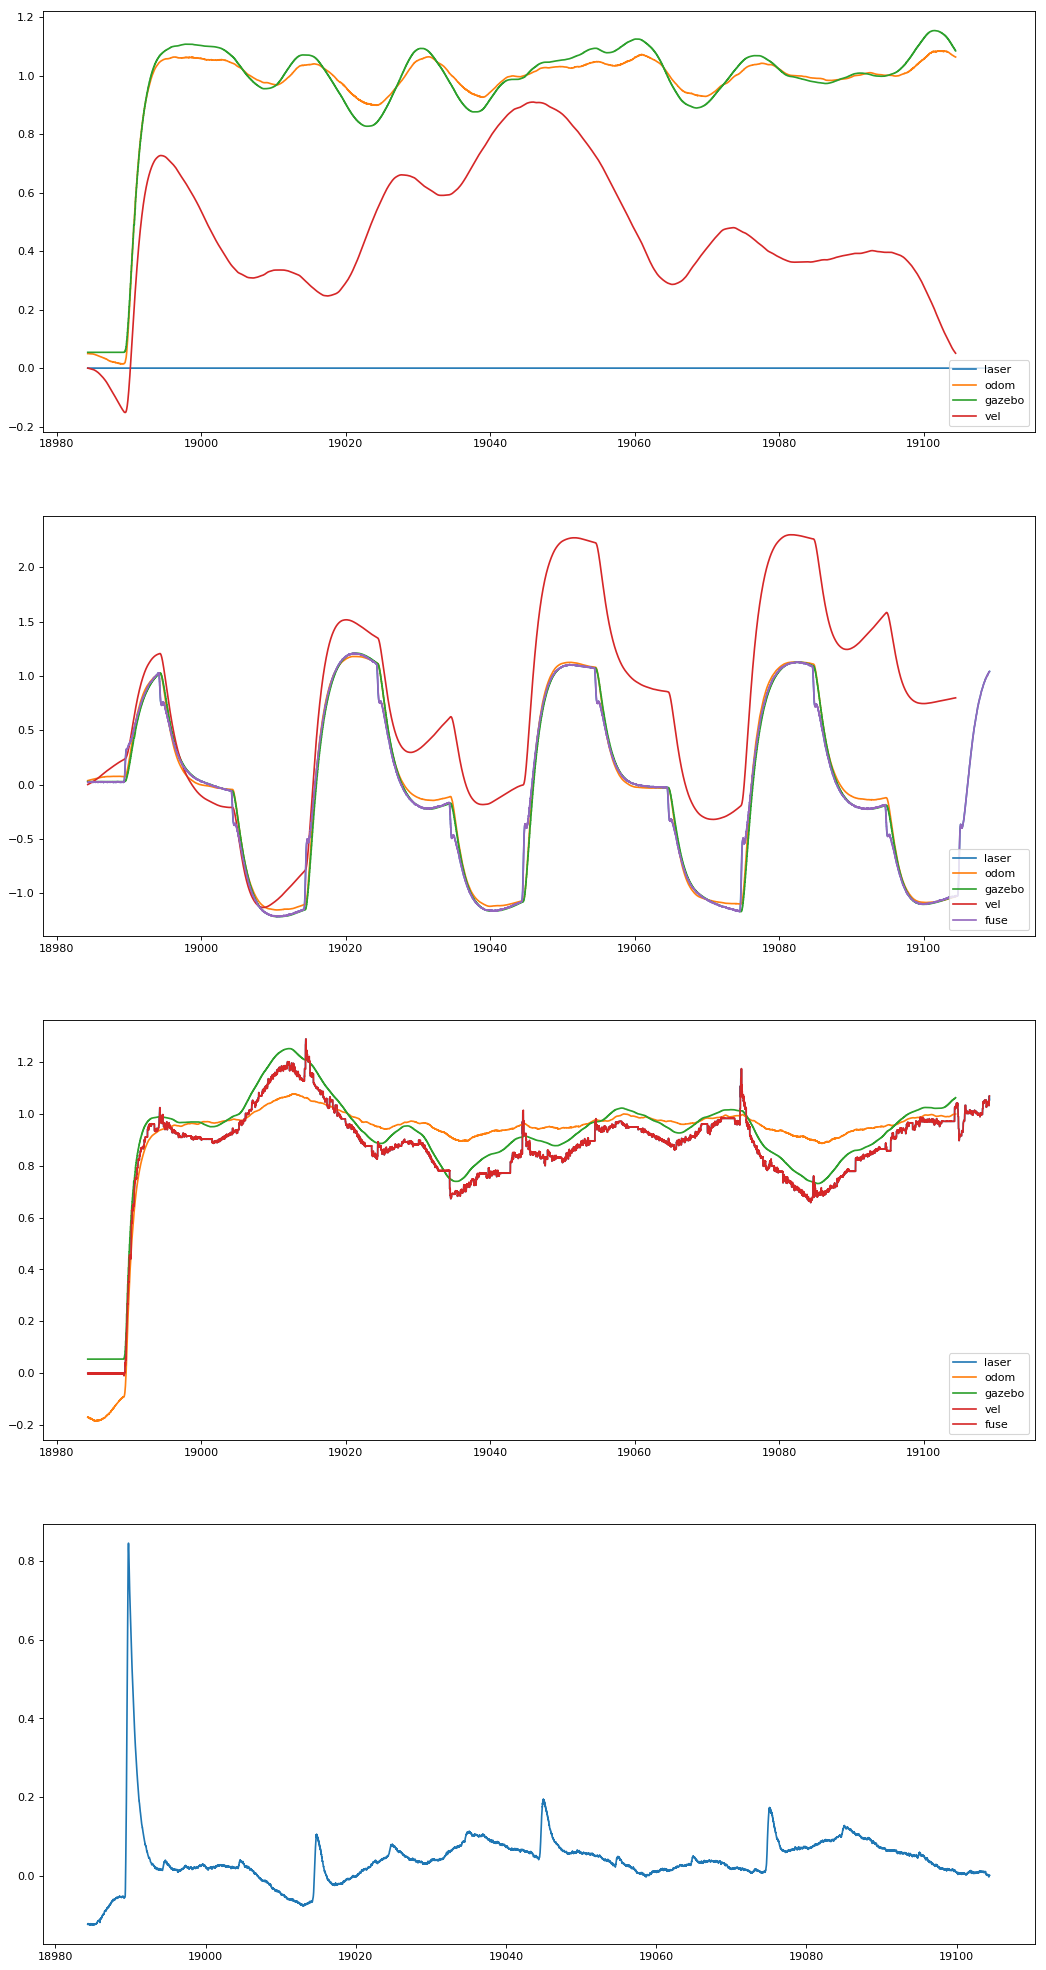

In [53]:
#变化成矩阵方便出图   
laser_x = np.array(laser_x)
laser_y = np.array(laser_y)
laser_z = np.array(laser_z)

gazebo_x = np.array(gazebo_x)
gazebo_y = np.array(gazebo_y)
gazebo_z = np.array(gazebo_z)
gazebo_roll = np.array(gazebo_roll)
gazebo_pitch = np.array(gazebo_pitch)
gazebo_yaw = np.array(gazebo_yaw)

odom_x = np.array(odom_x)
odom_y = np.array(odom_y)
odom_z = np.array(odom_z)
odom_roll = np.array(odom_roll)
odom_pitch = np.array(odom_pitch)
odom_yaw = np.array(odom_yaw)
odom_velx = np.array(odom_velx)
odom_vely = np.array(odom_vely)
odom_velz = np.array(odom_velz)

vel_x = np.array(vel_x)
vel_y = np.array(vel_y)
vel_z = np.array(vel_z)

fuse_y =np.array(fuse_y)
fuse_z =np.array(fuse_z)

fuse_y_display = fuse_y[:,0:2]
fuse_z_display = fuse_z[:,0:2]



pl.figure(figsize=(16,32),dpi=80)

#x轴比较
pl.subplot(411)
laser = pl.plot(laser_x[:,0],laser_x[:,1])
odom = pl.plot(odom_x[:,0],odom_x[:,1])
gazebo = pl.plot(gazebo_x[:,0],gazebo_x[:,1])
vel = pl.plot(vel_x[:,0],vel_x[:,1])
pl.legend((laser[0], odom[0], gazebo[0], vel[0]),('laser', 'odom', 'gazebo', 'vel'),loc='lower right')

#y轴比较
pl.subplot(412)
laser = pl.plot(laser_y[:,0],laser_y[:,1])
odom = pl.plot(odom_y[:,0],odom_y[:,1])
gazebo = pl.plot(gazebo_y[:,0],gazebo_y[:,1])
vel = pl.plot(vel_y[:,0],vel_y[:,1])
fuse = pl.plot(fuse_y_display[:,0],fuse_y_display[:,1])
pl.legend((laser[0], odom[0], gazebo[0], vel[0], fuse[0]),('laser', 'odom', 'gazebo', 'vel', 'fuse'),loc='lower right')

#z轴比较
pl.subplot(413)
laser = pl.plot(laser_z[:,0],laser_z[:,1])
odom = pl.plot(odom_z[:,0],odom_z[:,1])
gazebo = pl.plot(gazebo_z[:,0],gazebo_z[:,1])
#vel = pl.plot(vel_z[:,0],vel_z[:,1])
fuse = pl.plot(fuse_z_display[:,0],fuse_z_display[:,1])
pl.legend((laser[0], odom[0], gazebo[0], vel[0],fuse[0]),('laser', 'odom', 'gazebo', 'vel', 'fuse'),loc='lower right')


pl.subplot(414)
pl.plot(odom_velz[:,0],odom_velz[:,1])
#pl.ylim(-1, 3)

pl.show()


# Filterpy

kalman filter
参数选取原则
首先按照动力学方程建立F方程
用H来选择有几个输入参数，这里我有四个参数，分别是y位置y速度,z位置z速度，xy轴的数据已经在之前的融合做完了所以这里H直接返回四个参数。
dim_x = 4， 不知道表示什么，
dim_z = 4 表示观测方程z有四个数
std_y, std_z，表示yz两轴的测量误差，我感觉激光雷达应该有3cm的精度，所以用了0.03
vstd表示速度测量误差，我写了个0.2发现结果还不错，但是感觉误差应该没那么大，但是速度测量结果其实不可信，所以写高了结果就不太好
Q噪声项，var这里我发现用0.2的结果比较好，目前还不知道为什么
P里头分别填上前面y位置y速度，z位置z速度能达到的最大值。
ukf.x = np.array([0., 0., 0., 0.])表示起始位置和起始速度都是0


In [56]:
from filterpy.kalman import UnscentedKalmanFilter as UKF
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import unscented_transform, MerweScaledSigmaPoints
from numpy.random import randn
import numpy as np

def f_cv(x, dt):
    """ state transition function for a 
    constant velocity aircraft"""
    
    F = np.array([[1, dt, 0,  0],
                  [0,  1, 0,  0],
                  [0,  0, 1, dt],
                  [0,  0, 0,  1]],dtype=float)
    return np.dot(F, x)

def h_cv(x):
    return np.array([x[0], x[1], x[2], x[3]])


ukf_fuse = []
std_y, std_z = 0.03, 0.003
vstd_y = 0.2
vstd_z = 0.007
dt = 0.005
ukf_fuse = np.hstack((fuse_y[:,1:3],fuse_z[:,1:3]))
ukf_time = fuse_y[:,0]

sigmas = MerweScaledSigmaPoints(4, alpha=.1, beta=2., kappa=-1.0)
ukf = UKF(dim_x=4, dim_z=4, fx=f_cv,
          hx=h_cv, dt=dt, points=sigmas)
ukf.x = np.array([0., 0., 0., 0.])
ukf.R = np.diag([std_y, vstd_y,std_z,vstd_z]) 
ukf.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.2)
ukf.Q[2:4, 2:4] = Q_discrete_white_noise(2, dt=dt, var=1)
ukf.P = np.diag([4**2, 1**2, 4**2, 1**2])
ukf_result = []
count = 0
for z in ukf_fuse:
    ukf.predict()
    ukf.update([z[0],z[1],z[2],z[3]])
    ukf_result.append(np.hstack((ukf_time[count],ukf.x)))
    count = count + 1
print "完成"
#print uxs



完成


In [ ]:
#有BUG，统计结果不准确，
#TODO 最好把时间统一一下，再相减
print np.shape(ukf_result)
print ukf_result[0]
mean = 0.0
i = 0
for usxtime in ukf_result:
    for gazebotime in gazebo_y:
        if usxtime[0] == gazebotime[0]:
            #print usxtime[1] - gazebotime[1]
            mean =  mean + np.square(usxtime[1] - gazebotime[1])
            break
    i = i+1
print "统计完成"
print mean,i

        

135.617885311 28792
313.570072691 28792
313.570093192
313.570295609 28792

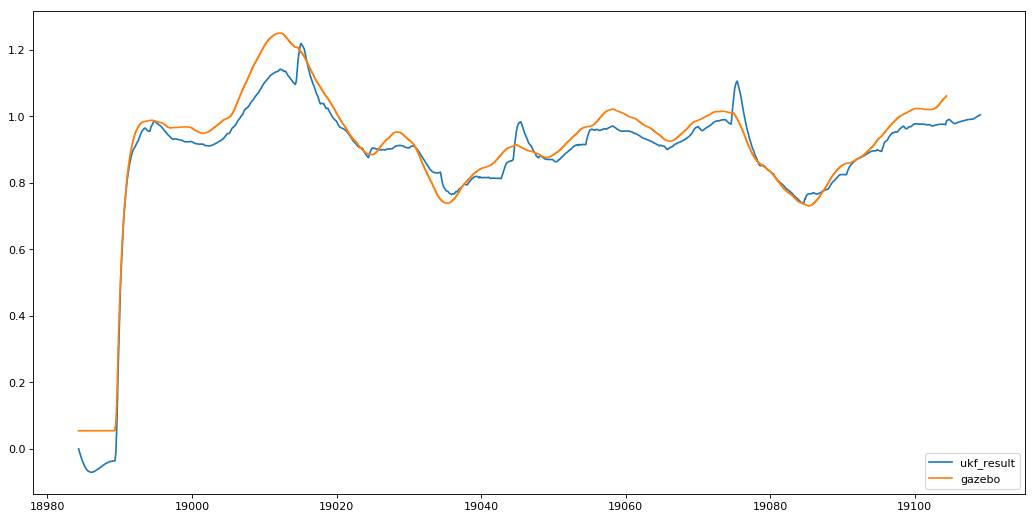

In [57]:
ukf_result = np.array(ukf_result)
plt.figure(figsize=(16,8),dpi=80)
ukf_result = plt.plot(ukf_result[:, 0],ukf_result[:, 3])
#fuse = pl.plot(fuse_y_display[:,0],fuse_y_display[:,1])
gazebo = pl.plot(gazebo_z[:,0],gazebo_z[:,1])

#fuse_y = plt.plot(ukf_fuse[:, 0], ukf_fuse[:, 1])
#ukf_fuse_z = plt.plot(ukf_fuse[:, 0], ukf_fuse[:, 1])

plt.legend((ukf_result[0],gazebo[0] ),('ukf_result', 'gazebo'),loc='lower right')

# PID control test

In [40]:
import PID
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import spline

def test_pid(P = 0.2,  I = 0.0, D= 0.0, L=100):
    """Self-test PID class

    .. note::
        ...
        for i in range(1, END):
            pid.update(feedback)
            output = pid.output
            if pid.SetPoint > 0:
                feedback += (output - (1/i))
            if i>9:
                pid.SetPoint = 1
            time.sleep(0.02)
        ---
    """
    pid = PID.PID(P, I, D)

    pid.SetPoint=0.0
    pid.setSampleTime(0.01)

    END = np.shape(gazebo_y_del)[0]
    feedback = 0

    feedback_list = []
    time_list = []
    setpoint_list = []
    
    print "PIDing"
    for i in range(1, END):
        pid.update(feedback)
        output = pid.output
        feedback += output
        pid.SetPoint = gazebo_y_del[i-1,1]
        time.sleep(0.005)


        feedback_list.append(feedback)
        setpoint_list.append(pid.SetPoint)
        time_list.append(i-1)

    time_sm = np.array(time_list)
    print "sm over"
    time_smooth = np.linspace(time_sm.min(), time_sm.max(), 30000)
    print "linespace over"
    #feedback_smooth = spline(time_list, feedback_list, time_smooth)
    #print feedback_list
    print "ploting"
    plt.figure(figsize=(8,8),dpi=80)
    plt.plot(time_list, feedback_list)
    plt.plot(time_list, setpoint_list)

    plt.xlabel('time (s)')
    plt.ylabel('PID (PV)')
    plt.title('TEST PID')


    print "showing"
    plt.grid(True)
    plt.show()



In [26]:
print "deleting"
gazebo_y_del = gazebo_y
for i in range(0,5000):
    gazebo_y_del = np.delete(gazebo_y_del, [0], axis =0)
for i in range(10000,23999):
    gazebo_y_del = np.delete(gazebo_y_del, [5000], axis =0)
print np.shape(gazebo_y_del)

deleting
(5001, 2)


PIDing
sm over
linespace over
ploting
showing


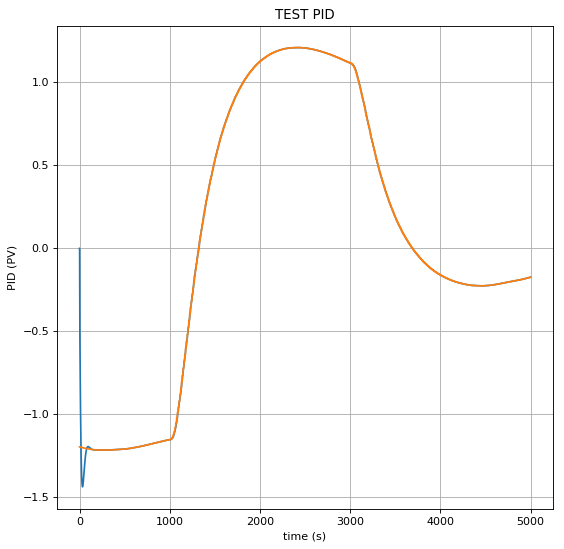

In [41]:
test_pid(0.1, 1, 0.001)

# python 动态可视化

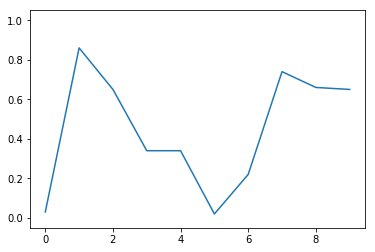

In [48]:
import numpy as np  
import matplotlib.pyplot as plt  
import matplotlib.animation as animation  
  
start = [1, 0.18, 0.63, 0.29, 0.03, 0.24, 0.86, 0.07, 0.58, 0]  
  
metric =[[0.03, 0.86, 0.65, 0.34, 0.34, 0.02, 0.22, 0.74, 0.66, 0.65],  
         [0.43, 0.18, 0.63, 0.29, 0.03, 0.24, 0.86, 0.07, 0.58, 0.55],  
         [0.66, 0.75, 0.01, 0.94, 0.72, 0.77, 0.20, 0.66, 0.81, 0.52]  
        ]  
  
fig = plt.figure()  
window = fig.add_subplot(111)  
line, = window.plot(start)  
#如果是参数是list,则默认每次取list中的一个元素,即metric[0],metric[1],...  
def update(data):  
    line.set_ydata(data)  
    return line,  
  
ani = animation.FuncAnimation(fig, update, metric, interval=2*1000)  
plt.show() 

In [8]:
import numpy
temp = [1,2,3]
temp1 = numpy.copy(temp)
print temp1
temp1 = numpy.delete(temp,1)
print temp



print numpy.arctan(5000)

[1 2 3]
[1, 2, 3]
1.5705963268
